In [1]:
# Libraries
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pickle
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from dotenv import load_dotenv
from supabase import create_client
import os

In [2]:
# Read data
load_dotenv()

SUPABASE_URL = os.getenv("NEXT_PUBLIC_SUPABASE_URL")
SUPABASE_SERVICE_KEY = os.getenv("NEXT_PUBLIC_SUPABASE_SERVICE_KEY")

supabase = create_client(SUPABASE_URL, SUPABASE_SERVICE_KEY)

MAKE = "Audi"
min_observations = 20

response = (
    supabase.table("bat_completed_auctions")
    .select("year, model, mileage, normalized_color, transmission, sold_price, bid_amount, end_date, status")
    .eq("make", MAKE)
    .not_.is_("mileage", None)
    .not_.is_("transmission", None)
    .execute()
)
df = pd.DataFrame(response.data)

In [3]:
# Top Prices by model
prices = df[['model','sold_price']].groupby('model').mean().sort_values(by='sold_price',ascending=False)
print(prices)

                                       sold_price
model                                            
R8 V10 GT                                254500.0
R8 V10 Plus Coupe Competition Package    242000.0
R8 V10 Plus Spyder                       222500.0
R8 V10 Plus Coupe 6-Speed                212449.5
R8 Performance V10 Spyder                187500.0
...                                           ...
TT 3.2 Coupe Quattro 6-Speed                  NaN
TT 6-Speed                                    NaN
Turbo Quattro Coupe                           NaN
V8 5-Speed                                    NaN
e-tron GT                                     NaN

[435 rows x 1 columns]


In [4]:
# Price by model
display_p=df[['model','year','sold_price']]

fig=px.box(display_p,x="model",y="sold_price")
fig.update_layout(title_text='Price vs Model',xaxis_title="Model",yaxis_title="Average Price")

In [5]:
# Filter to models with more than min_observations
counts=df['model'].value_counts()
frequent_models = counts[counts >= min_observations].index

# Filter the data to frequent models
df = df[df['model'].isin(frequent_models)]
popular_labels=frequent_models

colors=['lightslategray',]*len(popular_labels)
colors[0]='crimson'

fig=go.Figure(data=[go.Bar(x=counts[:25],y=popular_labels,marker_color=colors,orientation='h')])
fig.update_layout(title_text='Most represented Models in the Dataset',xaxis_title="Count",yaxis_title="Model")

In [6]:
#distribution of number of cars over the years
dic = {1970+i : sum(df['year']==1970+i) for i in range(55)}
x_dic = [1970 + i for i in range(55)]
y_dic = [dic[1970 + i] for i in range(55)]

# Plot
fig = go.Figure([go.Bar(x=x_dic, y=y_dic)])

fig.update_layout(title="Car year distribution",
                  xaxis_title="Year",
                  yaxis_title="Count Cars sold")


fig.show()

In [7]:
# Distribution of transmission
data_pie = df['transmission'].value_counts()

fig = go.Figure(data=[go.Pie(labels=data_pie.index, values=data_pie.tolist(), textinfo='label+percent',insidetextorientation='radial')])

fig.update_traces(hole=.3, hoverinfo="label+percent+name")

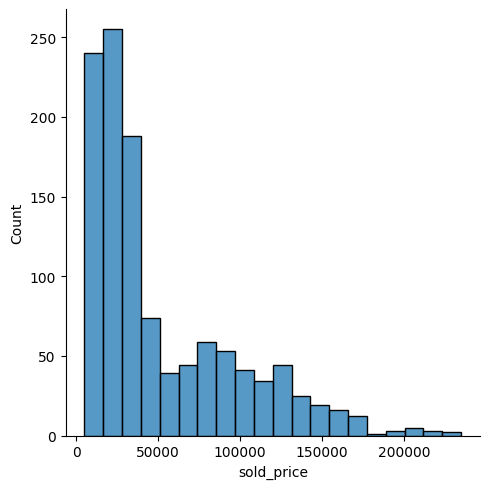

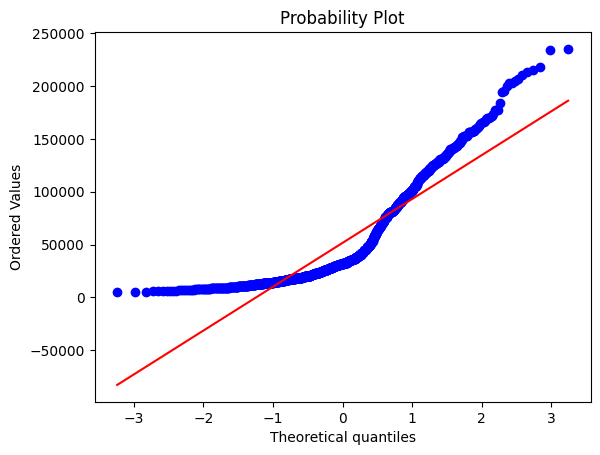

In [8]:
# Replace sold_price with bid_amount and remove outliers
df['sold_price'] = df['sold_price'].fillna(df['bid_amount'])
df = df.dropna()

# Remove outliers
price_threshold = 1000000
df.drop(df[df['sold_price'] >= price_threshold].index,inplace=True)

# Plot distribution of sold_price
sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'mileage'}>],
       [<Axes: title={'center': 'sold_price'}>,
        <Axes: title={'center': 'bid_amount'}>]], dtype=object)

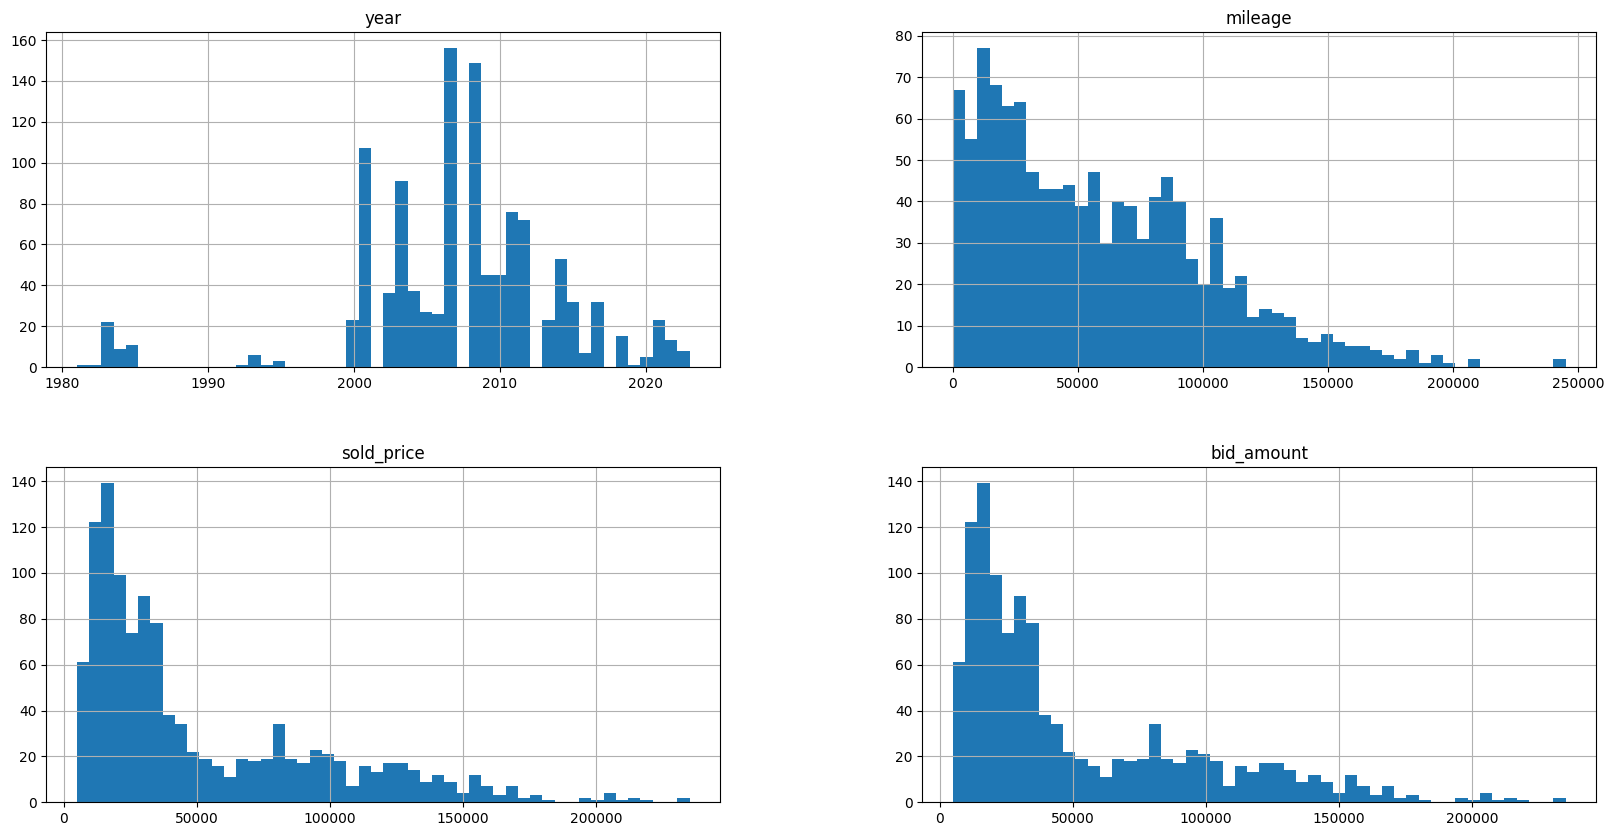

In [9]:
# Data distribution
df.hist(figsize=(20,10),bins = 50)

In [10]:
# Weight by recency
df['days_since_end'] = (pd.to_datetime(date.today()) - pd.to_datetime(df["end_date"])).dt.days
K = 1
T = 360
df['W'] = K*np.exp(-df['days_since_end']/T)


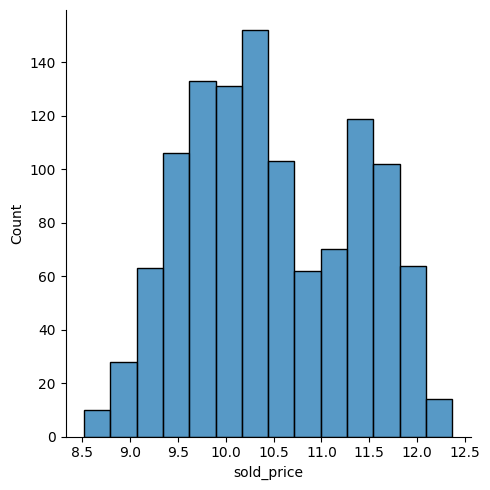

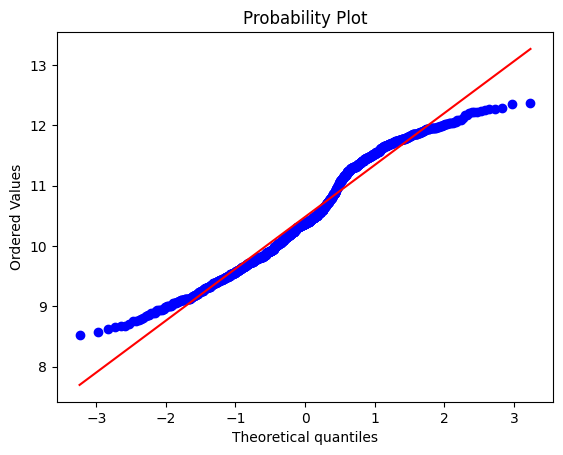

In [11]:
#Log transform sold_price & mileage
df['sold_price'] = np.log(df['sold_price'])
df['mileage'] = np.log1p(df['mileage'])

sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)

In [12]:
# Summarize transformed data
df.describe()

,year,mileage,sold_price,bid_amount,days_since_end,W
count,1157.000000,1157.000000,1157.000000,1157.000000,1157.00000,1157.000000
mean,2007.310285,10.546640,10.482615,51668.258427,988.32325,0.221544
std,7.145643,1.126994,0.871102,45369.997449,741.65982,0.265482
min,1981.000000,2.995732,8.517193,5000.000000,1.00000,0.000091
25%,2003.000000,9.952325,9.798127,18000.000000,373.00000,0.019852
50%,2008.000000,10.839601,10.373491,32000.000000,839.00000,0.097242
75%,2011.000000,11.373675,11.289782,80000.000000,1411.00000,0.354832
max,2023.000000,12.409018,12.367341,235000.000000,3348.00000,0.997226


In [13]:
# Prepare target and features
y = df["sold_price"]
X = df.drop(["sold_price","bid_amount","end_date", "status", "days_since_end"],axis=1)
X

,year,model,mileage,normalized_color,transmission,W
250,2008,A8L,11.326608,Gray,automatic,0.409972
251,2012,A8L,11.891369,Gray,automatic,0.524954
252,2015,A8L,11.512935,Silver,automatic,0.880049
253,2009,A8L,11.373675,Black,automatic,0.738763
254,2011,A8L,11.362114,Silver,automatic,0.691118
...,...,...,...,...,...,...
2323,1983,Ur-Quattro,11.561725,Black,automatic,0.007243
2324,1984,Ur-Quattro,11.626263,Gray,manual,0.007103
2326,1983,Ur-Quattro,11.314487,Beige,manual,0.000113
2327,1984,Ur-Quattro,11.127278,Red,manual,0.001422


In [14]:
# Encode categorical features
Lbl_model = LabelEncoder()
Lbl_color = LabelEncoder()
Lbl_trans = LabelEncoder()

#df.make=Lbl.fit_transform(df.make)
X.model=Lbl_model.fit_transform(df.model)
print("Model Mapping:", dict(zip(Lbl_model.classes_, Lbl_model.transform(Lbl_model.classes_))))
X.normalized_color=Lbl_color.fit_transform(df.normalized_color)
print("Color Mapping:", dict(zip(Lbl_color.classes_, Lbl_color.transform(Lbl_color.classes_))))
X.transmission =Lbl_trans.fit_transform(df.transmission)
print("Trans Mapping:", dict(zip(Lbl_trans.classes_, Lbl_trans.transform(Lbl_trans.classes_))))
X

Model Mapping: {'A8L': 0, 'Quattro': 1, 'R8 6-Speed': 2, 'R8 Coupe': 3, 'R8 Coupe 6-Speed': 4, 'R8 V10 6-Speed': 5, 'R8 V10 Coupe': 6, 'R8 V10 Coupe 6-Speed': 7, 'R8 V10 Plus Coupe': 8, 'R8 V10 Spyder': 9, 'R8 V10 Spyder 6-Speed': 10, 'RS4': 11, 'RS4 Cabriolet': 12, 'RS6': 13, 'RS6 Avant': 14, 'S4': 15, 'S4 6-Speed': 16, 'S4 Avant 6-Speed': 17, 'S6': 18, 'S8': 19, 'TT RS': 20, 'TT Roadster 225 Quattro 6-Speed': 21, 'Ur-Quattro': 22}
Color Mapping: {'Beige': 0, 'Black': 1, 'Blue': 2, 'Brown': 3, 'Gray': 4, 'Green': 5, 'Maroon': 6, 'Orange': 7, 'Pink': 8, 'Purple': 9, 'Red': 10, 'Silver': 11, 'Unknown': 12, 'White': 13, 'Yellow': 14}
Trans Mapping: {'automatic': 0, 'manual': 1}


,year,model,mileage,normalized_color,transmission,W
250,2008,0,11.326608,4,0,0.409972
251,2012,0,11.891369,4,0,0.524954
252,2015,0,11.512935,11,0,0.880049
253,2009,0,11.373675,1,0,0.738763
254,2011,0,11.362114,11,0,0.691118
...,...,...,...,...,...,...
2323,1983,22,11.561725,1,0,0.007243
2324,1984,22,11.626263,4,1,0.007103
2326,1983,22,11.314487,0,1,0.000113
2327,1984,22,11.127278,10,1,0.001422


In [15]:
# Fit Model
# Features
# year	model	mileage	normalized_color	transmission

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = True)

car_model_rf = RandomForestRegressor(n_estimators=100, random_state=33, monotonic_cst = [0,0,-1,0,0,0])
car_model_rf.fit(X_train,y_train, sample_weight=X_train['W'])
print('Random Forest Regressor Train Score is : ' ,  car_model_rf.score(X_train, y_train))
print('Random Forest Regressor Test Score is : ' , car_model_rf.score(X_test, y_test)) 

predicted_rf = pd.DataFrame(car_model_rf.predict(X_test), index=X_test.index, columns=['predicted_rf'])
car_model_rf.feature_importances_


Random Forest Regressor Train Score is :  0.9355022608701051
Random Forest Regressor Test Score is :  0.899099707284291


array([0.43489665, 0.26094679, 0.25363616, 0.01424007, 0.00725732,
       0.029023  ])

In [16]:
# Inverse transform features
X_analysis = X_test.copy()
X_analysis.model = Lbl_model.inverse_transform(X_test.model)
X_analysis.normalized_color = Lbl_color.inverse_transform(X_test.normalized_color)
X_analysis.transmission = Lbl_trans.inverse_transform(X_test.transmission)
X_analysis

,year,model,mileage,normalized_color,transmission,W
1765,2005,S4 Avant 6-Speed,11.608245,Blue,manual,0.015205
880,2015,R8 V10 Plus Coupe,9.798183,Gray,automatic,0.753269
614,2008,R8 Coupe 6-Speed,10.799596,Gray,manual,0.317518
920,2015,R8 V10 Spyder,9.392745,Black,automatic,0.263597
1529,2001,S4,10.545368,Yellow,manual,0.001290
...,...,...,...,...,...,...
2285,2013,TT RS,9.852247,Black,manual,0.001947
1180,2007,RS4,11.938200,Blue,manual,0.770195
1001,2011,R8 V10 Spyder 6-Speed,8.243019,Black,manual,0.040200
1778,2007,S4 Avant 6-Speed,11.532738,Blue,manual,0.168077


In [17]:
# Analyze Results: Add target and predicted values
X_analysis = pd.merge(y_test, X_analysis, how='inner', left_index=True, right_index=True)
X_analysis = pd.merge(X_analysis, predicted_rf, how='inner', left_index=True, right_index=True)
X_analysis.sold_price = np.exp(X_analysis.sold_price)
X_analysis.predicted_rf = np.exp(X_analysis.predicted_rf)
X_analysis.mileage = np.exp(X_analysis.mileage) - 1
X_analysis

,sold_price,year,model,mileage,normalized_color,transmission,W,predicted_rf
1765,25638.0,2005,S4 Avant 6-Speed,110000.0,Blue,manual,0.015205,14748.928692
880,101000.0,2015,R8 V10 Plus Coupe,18000.0,Gray,automatic,0.753269,113473.371439
614,66000.0,2008,R8 Coupe 6-Speed,49000.0,Gray,manual,0.317518,53072.628132
920,92500.0,2015,R8 V10 Spyder,12000.0,Black,automatic,0.263597,111754.212960
1529,17750.0,2001,S4,38000.0,Yellow,manual,0.001290,21913.252126
...,...,...,...,...,...,...,...,...
2285,45750.0,2013,TT RS,19000.0,Black,manual,0.001947,46844.085072
1180,18001.0,2007,RS4,153000.0,Blue,manual,0.770195,18996.081301
1001,171500.0,2011,R8 V10 Spyder 6-Speed,3800.0,Black,manual,0.040200,172868.124996
1778,22054.0,2007,S4 Avant 6-Speed,102000.0,Blue,manual,0.168077,15867.256915


In [18]:
# Define price ranges
def getrange(Price):
    if (Price >= 0 and Price < 50000):
        return '0 - 50000'
    if (Price >= 50000 and Price < 100000):
        return '50000 - 100000'
    if (Price >= 100000 and Price < 150000):
        return '100000 - 150000'
    if (Price >= 150000 and Price < 200000):
        return '150000 - 200000'
    if (Price >= 200000 and Price < 250000):
        return '200000 - 250000'
    if (Price >= 250000 and Price < 300000):
        return '250000 - 300000'
    if (Price >= 300000 and Price < 350000):
        return '300000 - 350000'
    if (Price >= 350000):
        return 'Over 350000'
X_analysis['Price Range'] = X_analysis['sold_price'].apply(lambda x:getrange(x))

X_analysis['Price Range'].value_counts()

Price Range
0 - 50000          150
50000 - 100000      40
100000 - 150000     30
150000 - 200000      9
200000 - 250000      3
Name: count, dtype: int64

<Axes: xlabel='sold_price', ylabel='predicted_rf'>

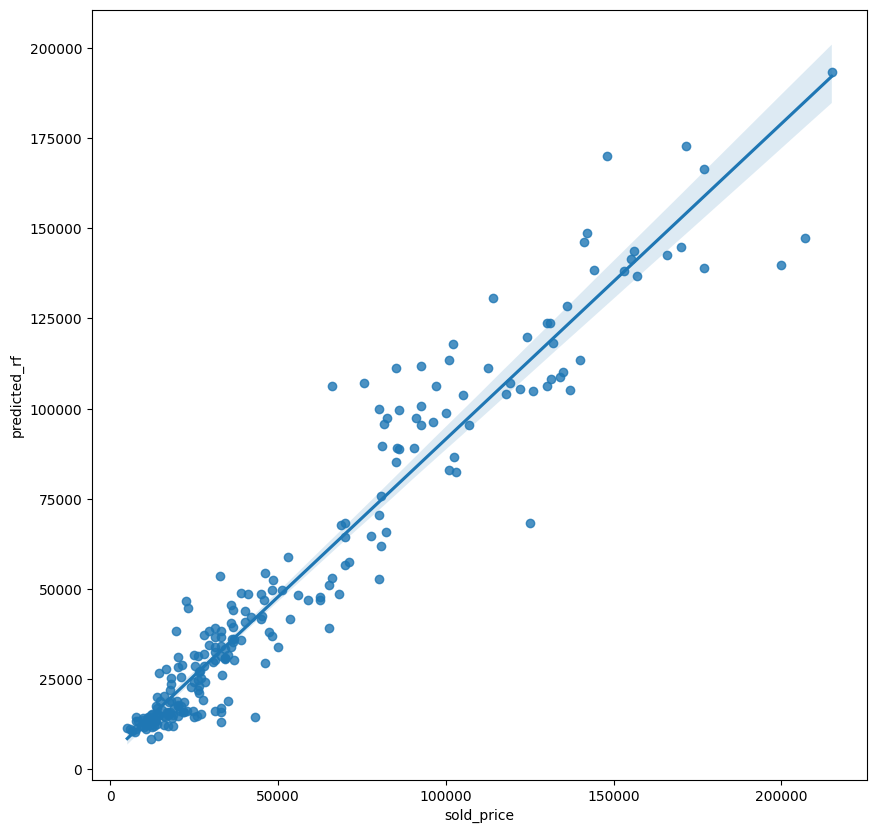

In [19]:
# Plot true vs predicted values scatter

plt.figure(figsize = (10, 10))
sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_rf)
#sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_xgb)

In [20]:
# Save model
today_date = date.today().strftime('%Y-%m-%d')
path = f"../models/{MAKE}"
if not os.path.exists(path):
    os.makedirs(path)

pickle.dump(car_model_rf, open(f'{path}/model.pkl','wb'))
pickle.dump(Lbl_model, open(f'{path}/labels_model.pkl','wb'))
pickle.dump(Lbl_color, open(f'{path}/labels_color.pkl','wb'))
pickle.dump(Lbl_trans, open(f'{path}/labels_transmission.pkl','wb'))

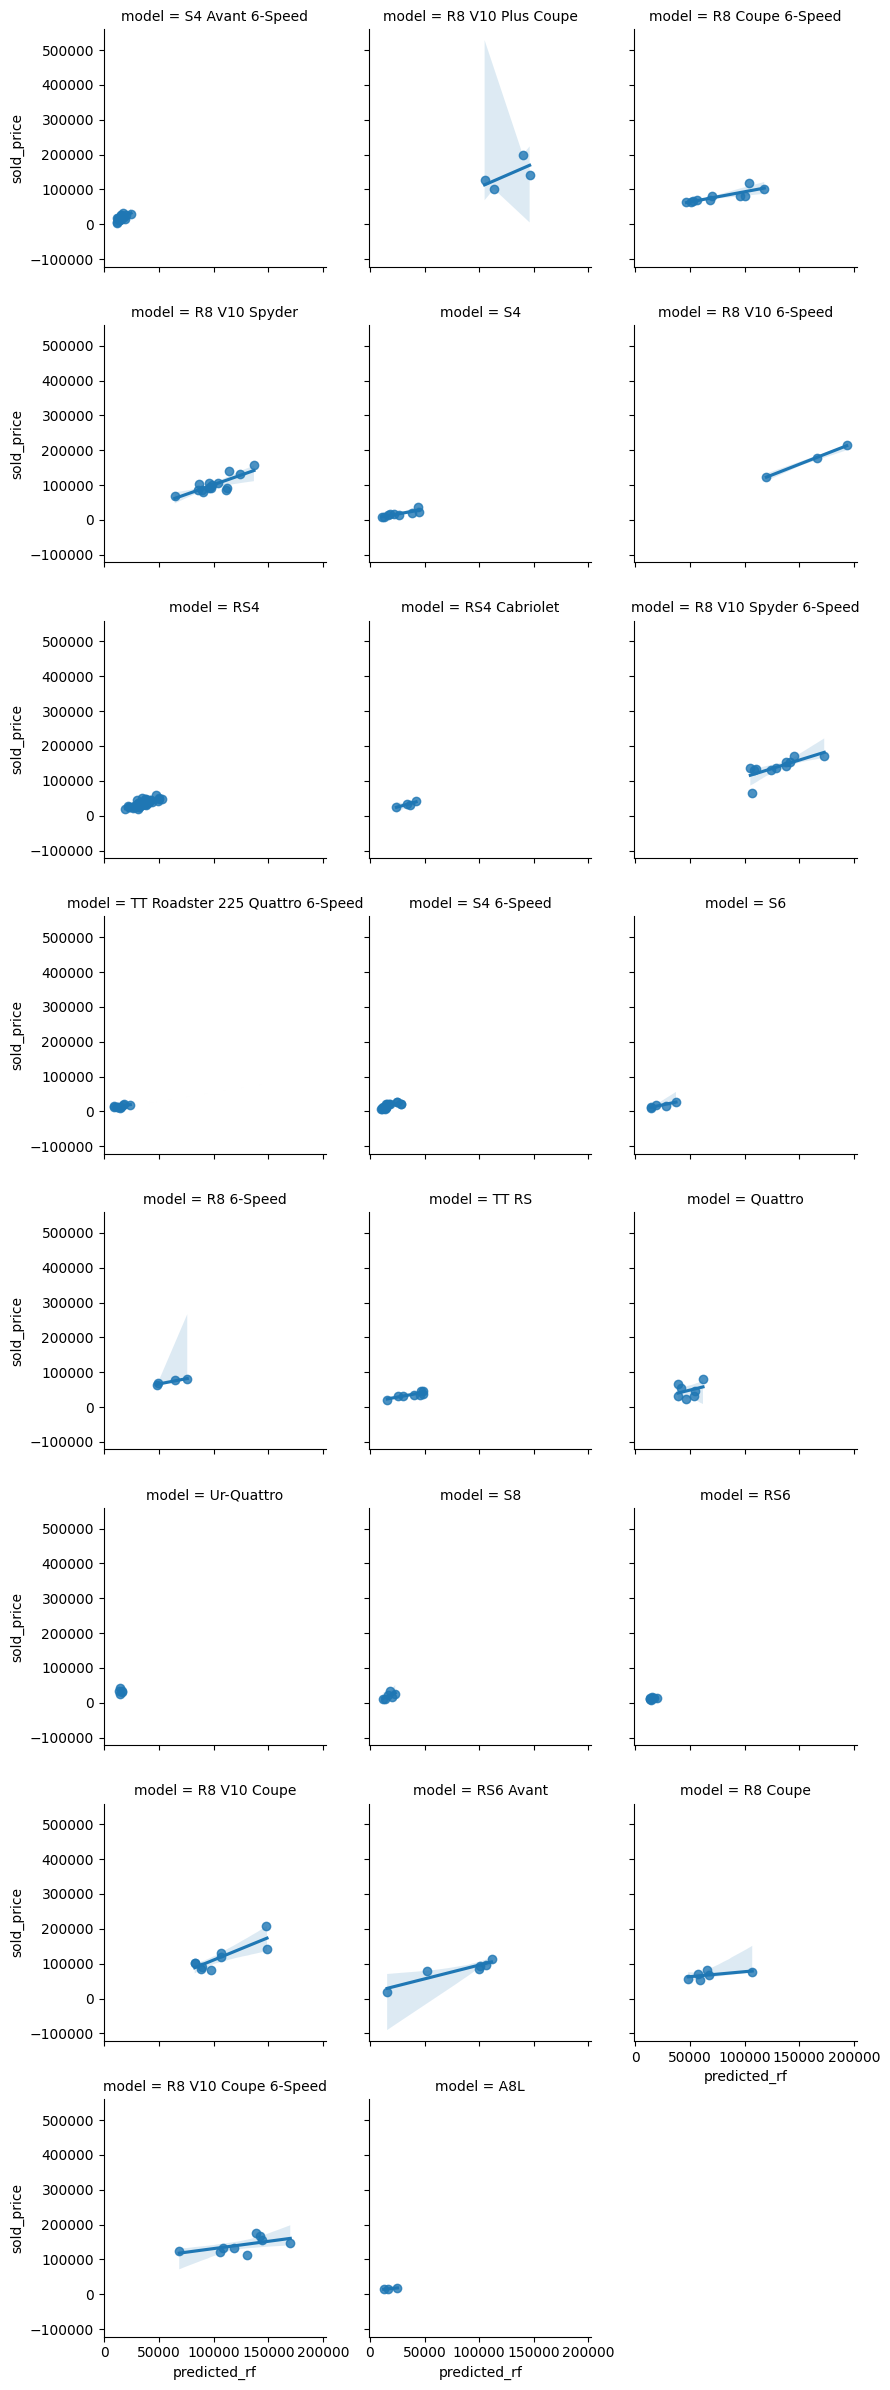

In [21]:
# Predicted vs Sold Price Scatter by model
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
g.map(sns.regplot, "predicted_rf", "sold_price")

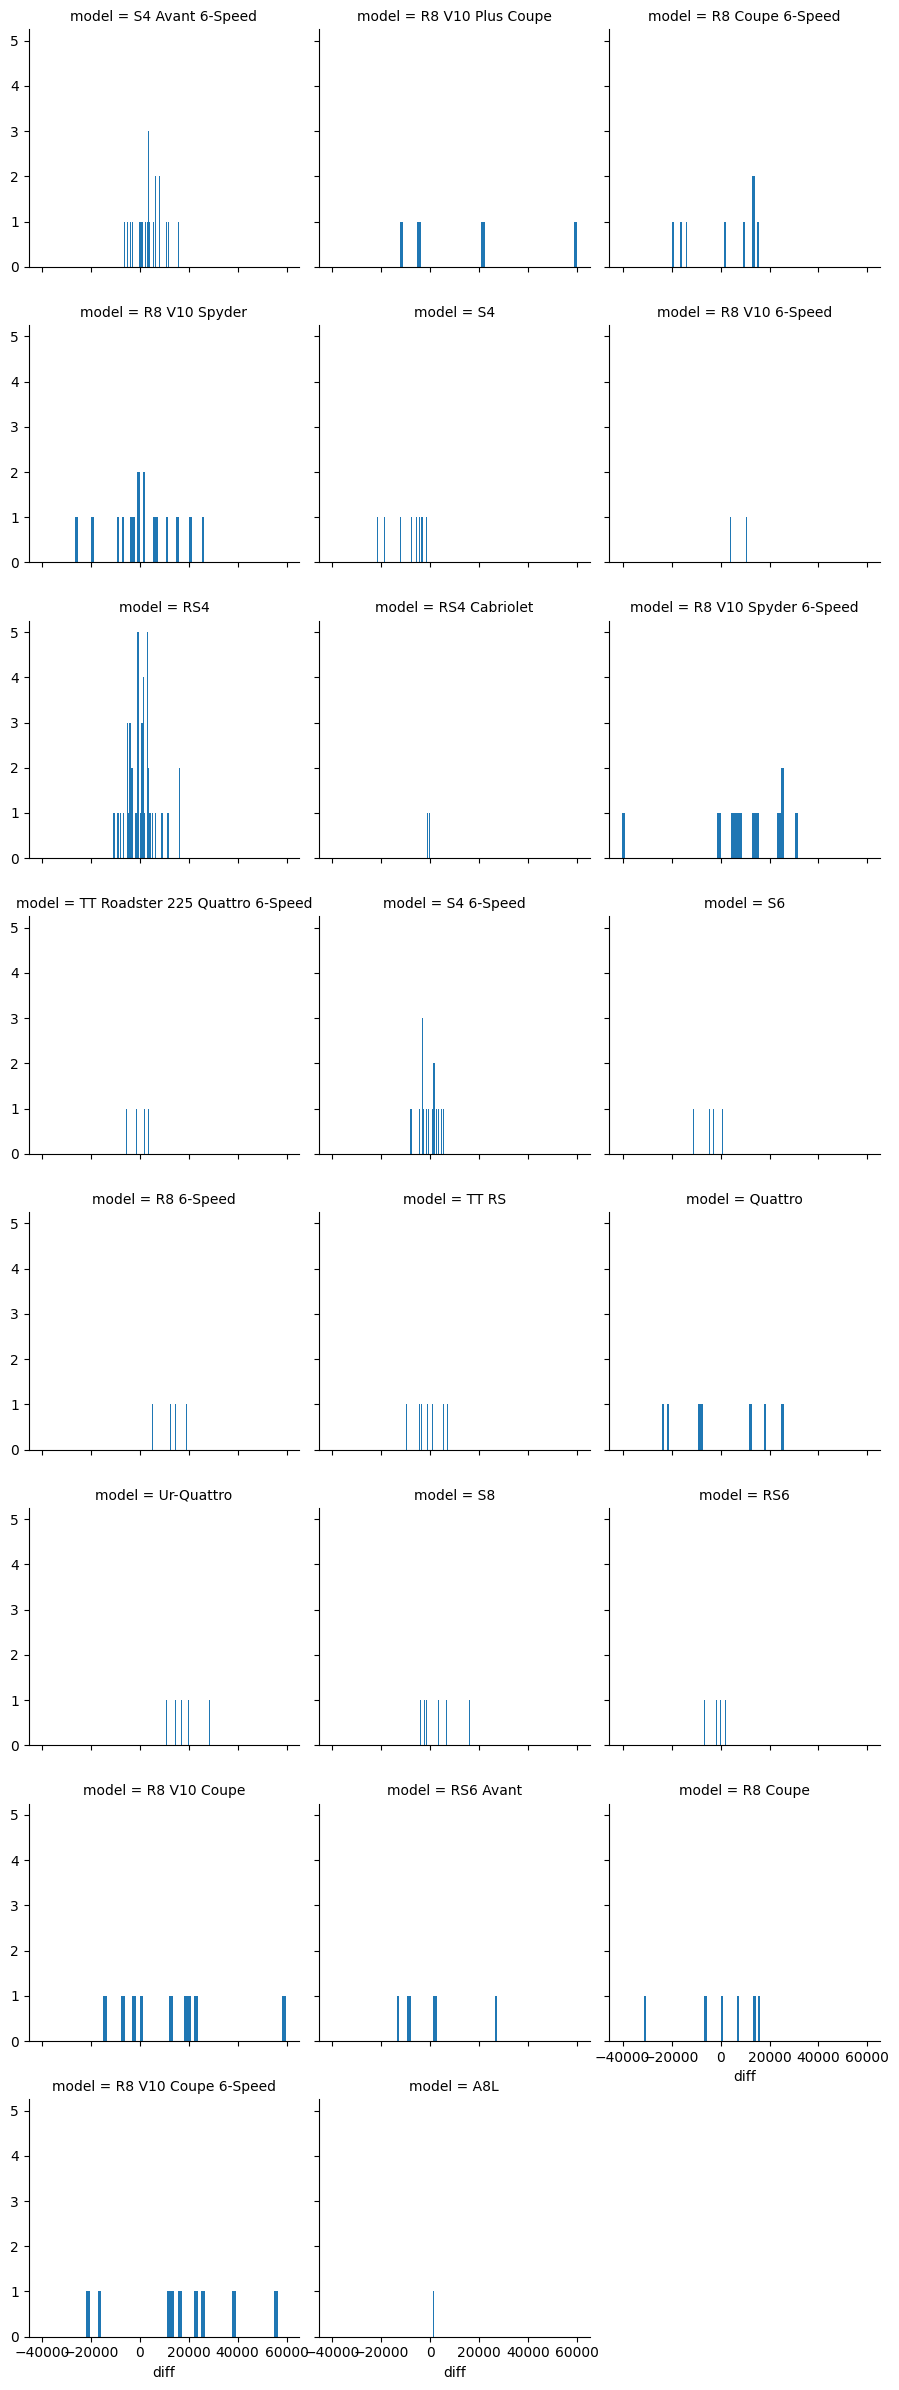

In [22]:
# Analyze Residuals by model
X_analysis['diff'] = X_analysis.sold_price - X_analysis.predicted_rf
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
g.map(plt.hist, "diff", bins = 50)


In [23]:
# Prediction function

def predict(year, model, mileage, color, transmission, carmodel, W):
    input_data = pd.DataFrame([[year, model, mileage, color, transmission, W]], 
                              columns=["year", "model", "mileage", "normalized_color", "transmission", "W"])
    input_data.model=Lbl_model.transform(input_data.model)
    input_data.normalized_color=Lbl_color.transform(input_data.normalized_color)
    input_data.transmission=Lbl_trans.transform(input_data.transmission)
    input_data.mileage = np.log1p(input_data.mileage)
    price_scaled = carmodel.predict(input_data)

    price = np.exp(price_scaled)
    
    return price[0].round(0)

In [24]:
# Run a prediction for a car over a range of mileage
mileage_range = np.linspace(0, 50000, 100)

predictions = []
for mileage in mileage_range:
    prediction = predict(
        year = 1992,
        model = "512 TR",
        mileage = mileage,
        color = "Black",
        transmission = "manual",
        carmodel = car_model_rf,
        W = 1
    )
    predictions.append(prediction)

predictions = pd.DataFrame(predictions, columns=["predicted"])
mileage_range = pd.DataFrame(mileage_range, columns=["mileage"])
predictions = pd.merge(predictions, mileage_range, how='inner', left_index=True, right_index=True)
plt.scatter(predictions["mileage"], predictions["predicted"])

ValueError: y contains previously unseen labels: '512 TR'